In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

# Optimizing the H2 Cavity

Having simulated and [analyzed the modes of the H2 Cavity](02_Analyzing_an_H2_Photonic_Crystal_Cavity.ipynb)
let us now try to optimize the Q factor of one of the supported modes.

We closely follow format as the legume tutorial
[Guided Mode Expansion with autograd](docs/examples/06_Guided_mode_expansion_with_autograd.ipynb).

## Construction
We start by constructing the crystal. The construction is differs from tutorial 2 as we want to preserve
symmetry in the four quadrants of the crystal.

We also define a constructor for the crystal "cavity(dx,dy)".This defines a parameterization of the
crystal for optimization. For purposes of illustration we will use a custom constructor as opposed to the
constructor provided by the pcc module. (Although the pcc module is functionally equivalent)

We choose to parameterize the displacement of all holes of the crystal with mirror symmetry across the x and y axis.
A more careful parameterization might be limited to holes near the center, introduce other symmetries, or parameterize
based on other factors such as hole size.

array([[11.56,  1.  ,  1.  , ...,  1.  ,  1.  , 11.56],
       [11.56,  1.  ,  1.  , ...,  1.  ,  1.  , 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       ...,
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56,  1.  ,  1.  , ...,  1.  ,  1.  , 11.56],
       [11.56,  1.  ,  1.  , ...,  1.  ,  1.  , 11.56]])

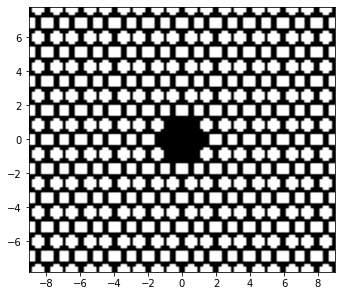

In [3]:
# Number of PhC periods in x and y directions
Nx, Ny = 18, 18
a=1
# Regular PhC parameters
dslab = 0.26/0.366*a
n_slab = 3.4
ra = 0.37*a


# Initialize a lattice and PhC
lattice = legume.Lattice([Nx*a, 0], [0, Ny*np.sqrt(3)/2*a])

# Make x and y positions in one quadrant of the supercell
# We only initialize one quadrant because we want to shift the holes symmetrically
xp, yp = [], []
nx, ny = Nx//2+1, Ny//2+1
for iy in range(ny):
    for ix in range(nx):
        if iy == 0 and ix in(0,1):
            continue
        if iy == 1 and ix ==0:
            continue
        xp.append(ix + (iy%2)*0.5)
        yp.append(iy*np.sqrt(3)/2)

nc = len(xp)

# Initialize shift parameters to zeros
dx, dy = np.zeros((nc,)), np.zeros((nc,))
r = np.ones((nc))
# Define H2 PhC cavity with shifted holes
def cavity(dx, dy):
    # Initialize PhC
    phc = legume.PhotCryst(lattice)

    # Add a layer to the PhC
    phc.add_layer(d=dslab, eps_b=n_slab**2)

    # Apply holes symmetrically in the four quadrants
    for ic, x in enumerate(xp):
        yc = yp[ic] if yp[ic] == 0 else yp[ic] + dy[ic]
        xc = x if x == 0 else xp[ic] + dx[ic]
        phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=ra))
        if nx-0.6 > xp[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=ra))
        if nx-1.6 > xp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=ra))
        if (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0 and nx-1.1 > xp[ic]:
            phc.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=ra))
    return phc

phc=cavity(dx,dy)
legume.viz.eps_xy(phc, z=dslab/2, Nx=100, Ny=100)

Care must be taken in the parametrization to avoid overlap at the edges of the crystal.
Note how the constructor avoids the edges of the mirrored quadrants.
We can see the effect of this below.

array([[11.56,  1.  ,  1.  , ...,  1.  ,  1.  , 11.56],
       [11.56,  1.  ,  1.  , ...,  1.  ,  1.  , 11.56],
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       ...,
       [11.56, 11.56,  1.  , ...,  1.  , 11.56, 11.56],
       [11.56,  1.  ,  1.  , ...,  1.  ,  1.  , 11.56],
       [11.56,  1.  ,  1.  , ...,  1.  ,  1.  , 11.56]])

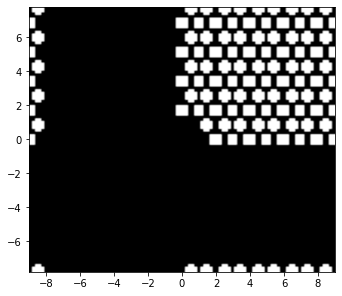

In [4]:
def cavity_quadrant_1(dx, dy):
    # Initialize PhC
    phc = legume.PhotCryst(lattice)

    # Add a layer to the PhC
    phc.add_layer(d=dslab, eps_b=n_slab**2)

    # Apply holes symmetrically in the four quadrants
    for ic, x in enumerate(xp):
        yc = yp[ic] if yp[ic] == 0 else yp[ic] + dy[ic]
        xc = x if x == 0 else xp[ic] + dx[ic]
        phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=ra))
        # Comment out the mirrored quadrants for demonstration
        """
        if nx-0.6 > xp[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=ra))
        if nx-1.6 > xp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=ra))
        if (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0 and nx-1.1 > xp[ic]:
            phc.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=ra))
        """
    return phc

phc_quad_1=cavity_quadrant_1(dx,dy)
legume.viz.eps_xy(phc_quad_1, z=dslab/2, Nx=100, Ny=100)

array([[11.56, 11.56, 11.56, ..., 11.56, 11.56, 11.56],
       [11.56, 11.56, 11.56, ..., 11.56, 11.56, 11.56],
       [11.56, 11.56, 11.56, ..., 11.56, 11.56, 11.56],
       ...,
       [11.56, 11.56, 11.56, ..., 11.56, 11.56, 11.56],
       [11.56, 11.56, 11.56, ..., 11.56, 11.56, 11.56],
       [11.56, 11.56, 11.56, ..., 11.56, 11.56, 11.56]])

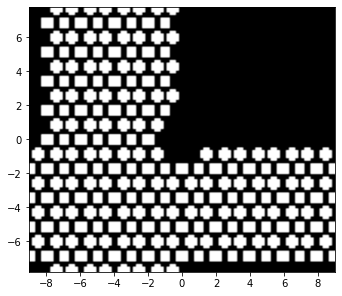

In [5]:
def cavity_quadrant_234(dx, dy):
    # Initialize PhC
    phc = legume.PhotCryst(lattice)

    # Add a layer to the PhC
    phc.add_layer(d=dslab, eps_b=n_slab**2)

    # Apply holes symmetrically in the four quadrants
    for ic, x in enumerate(xp):
        yc = yp[ic] if yp[ic] == 0 else yp[ic] + dy[ic]
        xc = x if x == 0 else xp[ic] + dx[ic]

        # Comment out the first quadrant for demonstration
        """
        phc.add_shape(legume.Circle(x_cent=xc, y_cent=yc, r=ra))
        """
        if nx-0.6 > xp[ic] > 0 and (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=-yc, r=ra))
        if nx-1.6 > xp[ic] > 0:
            phc.add_shape(legume.Circle(x_cent=-xc, y_cent=yc, r=ra))
        if (ny-1.1)*np.sqrt(3)/2 > yp[ic] > 0 and nx-1.1 > xp[ic]:
            phc.add_shape(legume.Circle(x_cent=xc, y_cent=-yc, r=ra))
    return phc
phc_quade_234=cavity_quadrant_234(dx,dy)
legume.viz.eps_xy(phc_quade_234, z=dslab/2, Nx=100, Ny=100)

See how the edges of the first quadrant overlap into the adjacent cells? If we added holes without considering this, the
holes would overlap. The guided mode expansion as implemented is not valid with overlapping holes.
We will also have to consider this when choosing the bounds of our parameter space.

## Objective Function

We now define our objective function. We will choose to minimize the loss rate of our crystal,
this is equivalent to maximizing Q (assuming constant frequency).

To minimize super cell effects see [Localization and Supercell Effects](04_Localization_and_Supercell_Effects.ipynb)
we will calculate our objective function over multiple k points and take the average.

The details of the construction of this figure of merit are given
in legume tutorial 7 [Enhancing your GME optimization](07_Enhancing_your_GME_optimization.ipynb).

In [6]:
from legume.primitives import fmap

def gme_cavity_k(dx, dy, gmax, options, kpoints):
    phc = cavity(dx, dy)

    options['compute_im'] = True

    gme = legume.GuidedModeExp(phc, gmax=gmax)
    gme.run(kpoints=kpoints, **options)

    mode_freq_im=gme.freqs_im[0][0]
    return gme, mode_freq_im

# Create a grid in k space (non-negative kx, ky only)
nkx = 2
nky = 2
kx = np.linspace(0, np.pi/Nx, nkx)
ky = np.linspace(0, np.pi/Ny/np.sqrt(3)*2, nky)
kxg, kyg = np.meshgrid(kx, ky)
kxg = kxg.ravel()
kyg = kyg.ravel()

def of_kavg_fmap(params):
    # A function factory to make a list of functions for every k-point
    def fim_factory(ik):
        def fim(params):
            dx = params[0:nc]
            dy = params[nc:]
            gme, mode_freq_im = gme_cavity_k(dx, dy, gmax, options, np.array([[kxg[ik]], [kyg[ik]]]))
            return mode_freq_im
        return fim
    fims = fmap([fim_factory(ik=ik) for ik in range(nkx*nky)], params)
    return npa.mean(fims)*1e6



## Bounds on parameters

What bounds on our parameters do we want? We need our holes to not overlap.
By default they are 1 unit away, with radius 0.344. So we should restrict their movement to be within

$d<\frac{1-2\cdot 0.37}{2}=0.13$

this translates to bounds on x and y of

$-0.09=-\frac{0.13}{\sqrt{2}}<dx<\frac{0.13}{\sqrt{2}}=0.09$

This is perhaps an overly restrictive bound, a more
sophisticated parameterization may be able to avoid overlap in a more lenient way,
nonetheless we declare:

In [7]:
# This will set the maximum displacement of holes in x and y at 0.11
bounds=[-0.09, 0.09]

## Choosing the target mode and settings for the guided mode expansion

In [Analyzing an H2 Photonic Crystal Cavity](02_Analyzing_an_H2_Photonic_Crystal_Cavity.ipynb)
we found a localized non-degenerate mode located at ~0.348 frequency with a relatively high Q factor.
Without more justification we will choose this mode to optimize.

The [eigsh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html) eigensolver
we will be using is a [Lanczos](https://en.wikipedia.org/wiki/Lanczos_algorithm) iterative eigensolver that
targets a frequency and finds the eigenmodes closest to that frequency. As opposed to the [eigh](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eigh.html)
solver the eigsh solver does not compute a diagonalization of the matrix, as a result it can be faster and
more memory efficient when only few modes need to be calculated.

For our purposes we only want to simulate 1 mode making the eisgh solver a natural choice.

We set up the GME options accordingly.

In [8]:
# Switch to autograd backend
legume.set_backend('autograd')

# Set up GME options
options = {'gmode_inds': [0],
           'verbose': False, # No need to clutter the optimization output.
           'gradients': 'exact',
           'numeig': 1, # We only need target mode
           'eig_sigma': 0.348,  # We want mode closest to this frequency.
           'eig_solver': 'eigsh' #
           }

## Simulating the target mode

Before we try optimizing the crystal first let's make sure we are simulating the mode we expect and calculate
the Q factor.

5.7564s total time for real part of frequencies, of which
  0.2876s for guided modes computation using the gmode_compute='exact' method
  0.8350s for inverse matrix of Fourier-space permittivity
  0.4860s for matrix diagionalization using the 'eigsh' solver
0.8790s for imaginary part computation
4265.782932344649


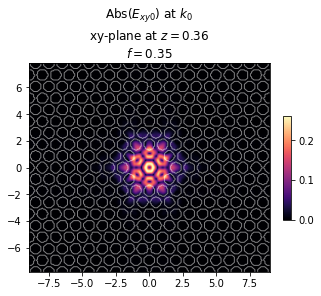

In [9]:
gmax = 1.5 # lowish gmax for demonstration
pstart = np.zeros((2*nc, ))

options["verbose"]=True

gme, freq_im= gme_cavity_k(pstart[0:nc], pstart[nc:], gmax, options, np.array([[kxg[0]], [kyg[0]]]))

legume.viz.field(gme, 'e', 0, 0, z=dslab/2, component='xy', val='abs', N1=200, N2=200,norm=True)
Q=gme.freqs[0][0]/2/freq_im
print(Q)

This is indeed the mode profile we expect to see from the data in
[Analyzing an H2 Photonic Crystal Cavity](02_Analyzing_an_H2_Photonic_Crystal_Cavity.ipynb).

## First attempt at optimization
Let's try optimizing this crystal on a single k point. We will see that there is a problem.

In [ ]:
nkx = 1 # only single point in grid for demonstration
nky = 1 #

opt = Minimize(of_kavg_fmap)

# Starting parameters are the un-modified cavity
options["eig_sigma"]=0.348
options["verbose"]=False
# Run an 'adam' optimization
(p_opt, ofs) = opt.adam(pstart, step_size=0.02, # Step size set too large for demonstration
                        Nepochs=6, bounds = bounds, pass_self=False)

We see that in the last epochs the loss rate spikes dramatically. What happened?
Let's visualize that final mode to understand:

In [ ]:
gme, freq_im,= gme_cavity_k(p_opt[0:nc], p_opt[nc:], gmax, options, np.array([[kxg[0]], [kyg[0]]]))

ax = legume.viz.field(gme, 'e', 0, 0, z=dslab/2, component='xy', val='abs', N1=200, N2=200,norm=True)

We see that this is not the same mode as we started with! Furthermore, it's not a mode that
we saw in our previous analysis of the H2 crystal mode structure.

We see as we have introduced more irregularities into the crystal modes have propagated in these defect regions.
On top of this the frequency of our target mode has drifted. The mode with frequency closest to
the target is now a "bonus mode" localized at the newly introduced defects of the crystal.

To avoid these bonus modes entirely a more careful parameterization is needed (although smaller step sizes help).
But we can at least avoid optimizing over them by being more sophisticated in how we choose the target frequency.

## Targeting frequency

A crude solution is to the frequency drift problem is to continually update the target frequency
as the target mode evolves.
We can redefine our objective function to account for this by defining a target frequency that
we update after each simulation.

In [10]:
opt_options = {'gmode_inds': [0],
           'verbose': False, # No need to clutter the optimization output.
           'gradients': 'exact',
           'numeig': 1, # We only need target mode
           'eig_sigma': 0.348,  # We want mode closest to this frequency.
           'eig_solver': 'eigsh'
           }

def gme_cavity_k_2(dx, dy, gmax, opt_options, kpoints):
    phc = cavity(dx, dy)
    opt_options['compute_im'] = True
    gme = legume.GuidedModeExp(phc, gmax=gmax)
    gme.run(kpoints=kpoints, **opt_options)

    mode_freq= gme.freqs[0][0]
    # The back propagation step of autograd wraps object attributes in an "ArrayBox" class to speed up the algorithm.
    # We want to assign the target frequency to a float, not an ArrayBox
    if mode_freq.__class__ == np.float64:
        opt_options['eig_sigma']=mode_freq

    mode_freq_im=gme.freqs_im[0][0]
    return gme, mode_freq_im

def of_kavg_fmap_2(params):
    # A function factory to make a list of functions for every k-point
    def fim_factory(ik):
        def fim(params):
            dx = params[0:nc]
            dy = params[nc:]
            gme, mode_freq_im = gme_cavity_k_2(dx, dy, gmax, opt_options, np.array([[kxg[ik]], [kyg[ik]]]))
            return mode_freq_im
        return fim
    fims = fmap([fim_factory(ik=ik) for ik in range(nkx*nky)], params)
    return npa.mean(fims)*1e6


## Second Attempt
We will now try again. This time with a larger k-grid, more epochs and a smaller step size.

At this point n we can run the optimization (which will take some time), or we can load a pickle file with
the final optimization object.

In [11]:
skip_wait = True

If you want to run the optimization your self, set the "skip_wait" parameter to false

In [12]:
import pickle

if skip_wait:
    opt = pickle.load(open("./aux_files/H2_opt.p", 'rb'))
    opt_options = pickle.load(open("./aux_files/H2_opt_run_options.p", 'rb'))


    p_opt = opt.params

    print("Pickled Epoch | Objective Function")
    for i, of in enumerate(opt.of_list):
        print("Epoch: %d | Objective: %4e" % (i+1, of))

else:
    nkx = 2 # only single point in grid for demonstration
    nky = 2 #

    opt = Minimize(of_kavg_fmap_2)


    opt_options["verbose"]=False


    # Run an 'adam' optimization
    (p_opt, ofs) = opt.adam(pstart, step_size=0.005, Nepochs=20, bounds = bounds)
    pickle.dump(opt, open("./aux_files/H2_opt.p", "wb"))
    # Dump the options associated with the GME run so we can reconstruct it from the parameters.
    pickle.dump(opt_options, open("./aux_files/H2_opt_run_options.p", "wb"))

# Optimized parameters
dx = p_opt[0:nc]
dy = p_opt[nc:]

Pickled Epoch | Objective Function
Epoch: 1 | Objective: 3.303585e+01
Epoch: 2 | Objective: 2.558462e+01
Epoch: 3 | Objective: 2.267768e+01
Epoch: 4 | Objective: 1.989884e+01
Epoch: 5 | Objective: 1.711949e+01
Epoch: 6 | Objective: 1.459503e+01
Epoch: 7 | Objective: 1.216773e+01
Epoch: 8 | Objective: 9.858089e+00
Epoch: 9 | Objective: 7.704396e+00
Epoch: 10 | Objective: 5.798810e+00
Epoch: 11 | Objective: 4.312239e+00
Epoch: 12 | Objective: 3.474062e+00
Epoch: 13 | Objective: 3.441662e+00
Epoch: 14 | Objective: 3.996986e+00
Epoch: 15 | Objective: 4.430506e+00
Epoch: 16 | Objective: 4.381172e+00
Epoch: 17 | Objective: 4.008088e+00
Epoch: 18 | Objective: 3.510942e+00
Epoch: 19 | Objective: 2.961372e+00
Epoch: 20 | Objective: 2.418363e+00


In [13]:
# Run the simulation
opt_gme, freq_im = gme_cavity_k(p_opt[0:nc], p_opt[nc:], gmax, opt_options, np.array([[kxg[0]], [kyg[0]]]))

Q_opt=opt_gme.freqs[0][0]/2/opt_gme.freqs_im[0][0]
print("Original Q value: %.2e, Optimized Q value: %.2e " %(Q, Q_opt))

Original Q value: 4.27e+03, Optimized Q value: 6.44e+04 


We see that in our new approach of tracking the frequency we have not drifted away from the mode we wanted to optimize
and increased the Q factor by an order of magnitude! But we will recall that the gmax we chose was rather low.
If we simulate this mode at a higher gmax what do we find?

In [14]:
gmax=3
opt_gme_2, freq_im_2s = gme_cavity_k(p_opt[0:nc], p_opt[nc:], gmax, opt_options, np.array([[kxg[0]], [kyg[0]]]))

Q_opt_2=opt_gme_2.freqs[0][0]/2/opt_gme_2.freqs_im[0][0]
print("Original Q value: %.2e, Optimized Q value: %.2e " %(Q, Q_opt_2))


Original Q value: 4.27e+03, Optimized Q value: 6.44e+04 


We see that despite optimizing with a low gmax the Q factor is similar and maintains the
order of magnitude increase we obtained from the optimization.

Let's visualize the optimized cavity below and calculate the Q factor:

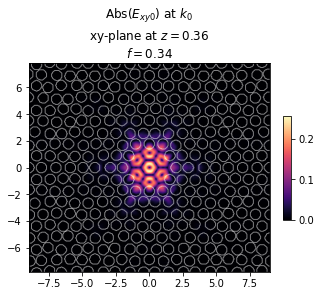

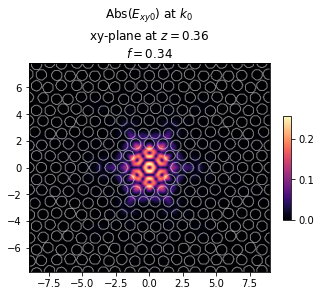

In [15]:
legume.viz.field(opt_gme, 'e', 0, 0, z=dslab/2, component='xy', val='abs', N1=300, N2=300, norm=True)

Many improvements can be made to this setup, including a more careful parameterization and more sophisticated methods of
targeting the mode to optimize. Running optimization algorithms in stages is common, for example tuning the
inner sections of holes before tuning sections rings. All of these kinds of innovations can be implemented in this
framework without much friction and so we leave it to the reader to determine the appropriate solution
for their context.

